#### Last Modified: Oct 6th, 2021 (Opal). 

# ROM- Operator Inference on Solar Wind Radial Speed $v_{r}$ dataset

In [94]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp, odeint
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [95]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [96]:
from code.hux_propagation import *
from code.numerical_methods import apply_numerical_method

# Import MHD solar wind velocity results.

In [97]:
# mas output - magnetic data, pressure, vr
mas_path = get_mas_path(cr="2210")
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [98]:
# read in MHD velocity results. 
vr_model = model['vr']

In [99]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = (vr_model.r_coords * u.solRad).to(u.km)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [100]:
# increase radial vector.
r_new = np.linspace(r[0], r[-1], 400)

In [108]:
# make phi grid coarse. 
p_new = np.linspace(p[0], p[-1], 150)

In [109]:
# number of phi indexes 
n = len(p_new) 
# spacing in phi (longitude)
dp = p_new[1] - p_new[0]

# Interpolate on a new grid. 

In [110]:
initial_condition_interp = interp1d(p, f[:, 55, 0], fill_value="extrapolate")

In [111]:
initial_condition = initial_condition_interp(p_new)

In [112]:
# solve the PDE using the upwind method. 
res = apply_forward_upwind_model(r_initial=initial_condition, 
                                 dr_vec=(r_new[1:]-r_new[:-1]).value, 
                                 dp_vec=p_new[1:] -p_new[:-1], 
                                 rh=50, 
                                 r0=30, 
                                 add_v_acc=False)

Radial and Longitude mesh spacing respect CFL condition of the given initial velocity profile at the Solar equator. 

* Longitude spacing 100 points: $\phi \in [0, 2\pi]$.

* Radial spacing 400 points: $r \in [30R_{\odot}, 215 R_{\odot}]$.

In [113]:
# omega rotation - solar rotation at the equator
omega_rot = (2 * np.pi) / (25.38* 86400)

In [114]:
v_at_30_radii_equator = initial_condition

# Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

# Reduced Order Model

We begin by assuming that the solar wind motion is described by the fluid momentum equation in corotating frame of reference.

\begin{equation} \label{momentum-equation}
-\Omega_{\text{rot}} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
\end{equation}

Where $v$ is the solar wind velocity, $\rho$ is the proton mass density, $P$ is the thermal pressure, $G$ is the gravitational constant, $r$ is the radial distance from the Sun, and $M_{s}$ is the solar mass. Unlike the conventional momentum equation, this Eq is time-stationary, in which the derivative with respect to time $\frac{\partial v}{\partial  t}$ in the conventional momentum equation has been swapped with $-\Omega_{\text{rot}}\frac{\partial v}{\partial  \phi}$ term. By neglecting the pressure gradient and gravity terms, which are assumed to be small in the heliosphere, the fluid momentum equation reduces to a nonlinear scalar homogeneous time-stationary equation, described by 

\begin{equation} \label{model}
\frac{\partial v}{\partial \phi} -\frac{1}{\Omega_{\text{rot}}}v\frac{ \partial v}{\partial r}=0
\end{equation}

where $r$ denotes the radial distance from the Sun,  $\phi$ denotes Carrington longitude in Heliographic (rotating) coordinate system (HG), and $v$ is the solar wind velocity in the radial direction. The initial-boundary value problem, or Cauchy problem with periodic initial data, is defined by Eq above on the domain $ r \geq 30 R_\odot$, $0 \leq \phi \leq 2 \pi$, where $\Omega_{\text{rot}}$ is the angular frequency of the Sun's rotation set equal to $\frac{2 \pi}{25.38} \text{1/days}$ at the solar equator, and more generally is a function of latitude.

\begin{equation} \label{omega-rot}
\Omega_{\text{rot}} (\theta) = \frac{2\pi}{25.38} - \frac{2.77\pi}{180} \cos(\theta)^2
\end{equation}

The two-dimensional model is subject to the initial condition
\begin{equation} \label{ic}
v(\phi, r_{0}) = v_{r_{0}}(\phi)
\end{equation}

with periodic boundary conditions, such that $v(0, r) = v(2\pi, r)$, for all radial locations. The underlying Eq would be considered in the form of the well-studied inviscid Burgers' equation if the propagation was in $\phi$ direction, although we are advancing in the radial direction; For instance, given an initial condition at $30 R\odot$, what is the solar wind speed near Earth at $1\text{AU}\approx 215R_\odot$? Now that we defined the problem, we are in the position to explore mathematical methods to solve our underlying equation. 


We can rewrite the underlying Eq in hyperbolic conservation  form

\begin{equation} \label{conservative-form}
    v_{r} + [f(v)]_{\phi} = 0 
\end{equation}

where the subscripts $r$ and $\phi$ denote the partial derivatives. The physical flux function is $f(v) = -\Omega_{\text{rot}} \ln(v)$ and because $f''(v) = \frac{\Omega_{\text{rot}}}{v^2} > 0$ $\forall v$, $f$ is said to be convex. When $f''(v)$ does not change signs, discontinuous solutions appear in the form of either compression or an expansion wave. 

Then, we can leverage the "upwind" scheme to approximate the derivative with respect to $\phi$ such that

$$
[f(v)]_{\phi} \approx \frac{-\Omega_{\text{rot}}}{\Delta \phi}  [\ln(v_{i, j + 1}) - \ln(v_{i, j})]
$$

where

$$
\begin{align*}
    A &= \frac{\Omega_{\text{rot}}}{\Delta \phi}\left[\begin{array}{ccccc}
        -1 & 1 & & & \\
        0 & -1 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & & -1 & 1 \\
        1 & & & 0 & -1 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{v}_0  \in\mathbb{R}^{n}.
\end{align*}
$$


we obtain the semi-discrete system

$$
\frac{d}{dr}\mathbf{v}(\phi, r) = A\ln(\mathbf{v}(\phi, r)),
$$


# Lifting to 3 variables for quadradic ODE form 

Let 

* $y = \ln(v)$

* $z = \frac{1}{v}$

* $\rho = \frac{1}{v} \odot (A \ln(v)) = z \odot (Ay)$ 

* $\gamma = A\rho$

Then, 

$$
\dot v = A \ln(v) = A y
$$

$$
\dot y = \frac{1}{v} \dot v = z \odot (A y) = \rho 
$$

$$
\dot z = \frac{-1}{v^2} \dot v = -z \odot z \odot (A y) = -z \odot \rho 
$$

By the product rule, 
$$
\dot \rho = \dot z \odot (Ay) + z \odot (A \dot y) = -\rho \odot z \odot (A y) + z \odot (A\rho) = -\rho^2 + z \odot (A \rho) = -\rho^2 + z \odot \gamma
$$


$$
\dot \gamma = A \dot \rho = A[-\rho^2 + z \odot \gamma] = -A \rho^{2} + A z \odot \gamma
$$



where $\odot$ denotes the Hadamard product (also known as the element-wise product). 


Leading to a system of 3 variables:


$$
\dot z =  -z \odot \rho 
$$
 
$$
\dot \rho = -\rho^2 + z \odot \gamma
$$


$$
\dot \gamma = -A (\rho^{2}) + A (z \odot \gamma)
$$

# FOM in vector form 

Let $n$ be the number of mesh points in Longitude, and $m$ be the number of mesh points in the radial direction. 

Let $x = \left[\begin{matrix} z & \rho & \gamma \end{matrix}\right]^{T}$ such that the full snapshot matrix is $X \in \mathbb{R}^{3n \times m}$.

$$
\dot x = \mathbf{H} (x \otimes x)
$$

such that $\mathbf{H} \in \mathbb{R}^{3n \times 9n^2}$. 

In [115]:
# add an acceleration boost to the initial condition. 
# set up hyper-parameters for acceleration. 
r0=30 
alpha=0.15
rh=50 

# acceleration boost. 
v_acc = alpha * (v_at_30_radii_equator * (1 - np.exp(-r0 / rh)))
v_at_30_radii_equator += v_acc 

In [116]:
# Construct the state matrix A.
diags = np.array([-1,1]) 
A = sparse.diags(diags, [0, 1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
fv = lambda t,x: A_mat @ np.log(x)

print(f"shape of A:\t{A.shape}")
print(f"shape of x0:\t{v_at_30_radii_equator.shape}")

shape of A:	(150, 150)
shape of x0:	(150,)


In [117]:
A_mat = A.toarray()

In [118]:
A_mat[-1, 0] = 1

In [119]:
A_mat = A_mat*(omega_rot)/(dp)

In [120]:
# Compute snapshots by solving the full-order model with SciPy.
V = solve_ivp(fv, [r_new[0].value,r_new[-1].value], 
              v_at_30_radii_equator, t_eval=r_new.value, method="BDF", 
              max_step=(r_new[1] - r_new[0]).value).y
print(f"shape of V:\t{V.shape}")

shape of V:	(150, 400)


# Introduce new variables in lifted coordinates $[z, \rho, \gamma]$

In [121]:
# y = ln(v)
Y = np.log(V)

# z = 1/v
Z = 1./V

# rho = z A y
P = Z * (A_mat @ Y)

# gamma = A rho
G = A_mat @ P

In [122]:
print(f"shape of V:\t{V.shape}")
print(f"shape of Y:\t{Y.shape}")
print(f"shape of Z:\t{Z.shape}")
print(f"shape of P:\t{P.shape}")
print(f"shape of G:\t{G.shape}")

shape of V:	(150, 400)
shape of Y:	(150, 400)
shape of Z:	(150, 400)
shape of P:	(150, 400)
shape of G:	(150, 400)


In [123]:
def plot_heat_data(Z, title, sample_columns=np.arange(0, len(r_new), 65), variable="v", savefig=False):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p_new*(180/np.pi), Z[:,j], color=next(color), 
                label=str(variable) + rf"$(\phi,r_{{{j +1}}}$" + "=" + 
                str(round(r_new[j].to(u.AU).value,3)) + " AU)")

    ax.set_xlabel(r"$\phi$ (Deg.)")
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(str(variable) + r"$(\phi,r)$")
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(title)
    
    if savefig:
        plt.savefig("figs/" + str(variable) + ".png",  bbox_inches='tight')

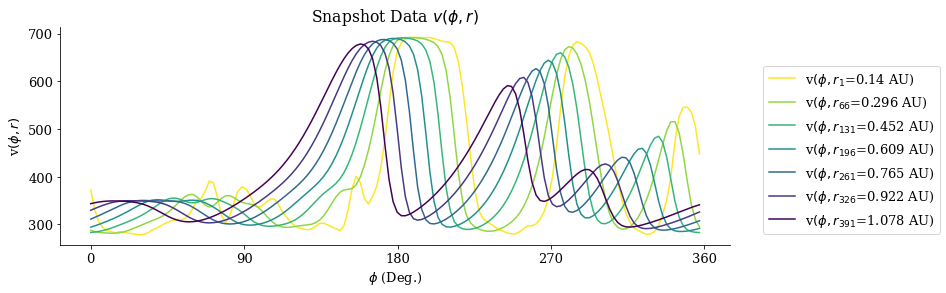

In [124]:
plot_heat_data(V, "Snapshot Data $v(\phi, r)$", variable="v", savefig=True)

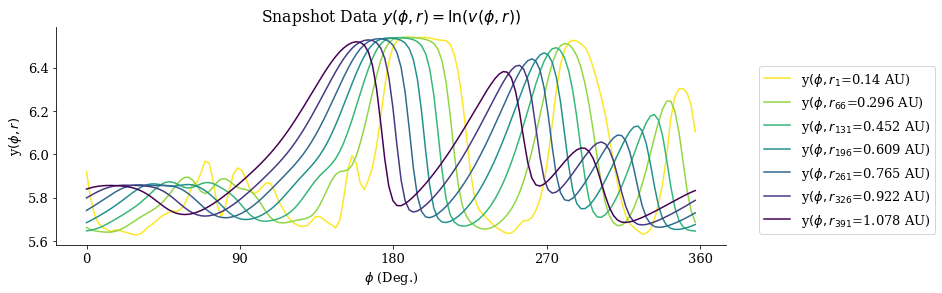

In [125]:
plot_heat_data(Y, "Snapshot Data $y(\phi, r) = \ln(v(\phi, r))$", variable="y", savefig=True)

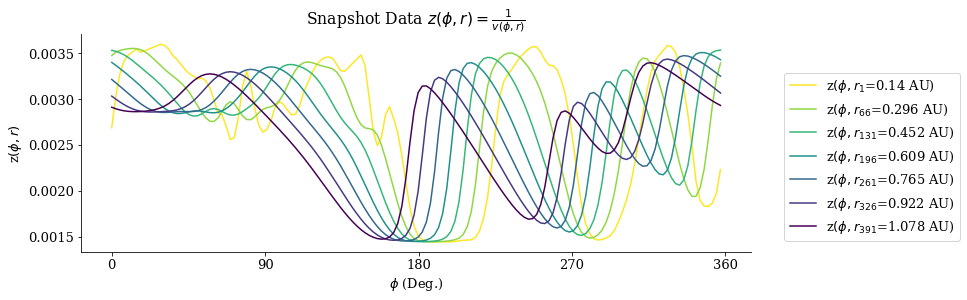

In [126]:
plot_heat_data(Z, r"Snapshot Data $z(\phi, r) = \frac{1}{v(\phi, r)}$", variable="z", savefig=True)

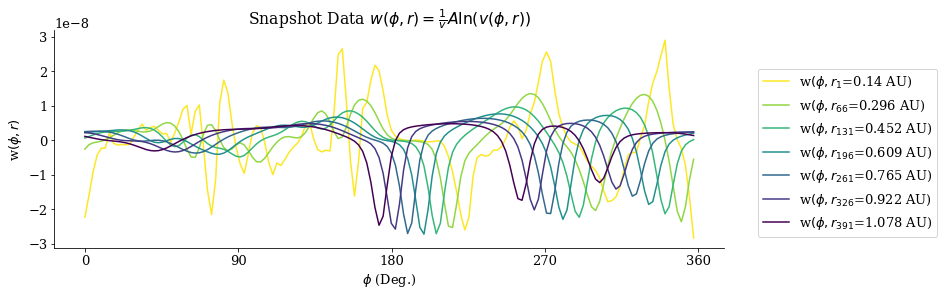

In [127]:
plot_heat_data(P, r"Snapshot Data $w(\phi, r) = \frac{1}{v} A\ln(v(\phi, r))$", variable="w", savefig=True)

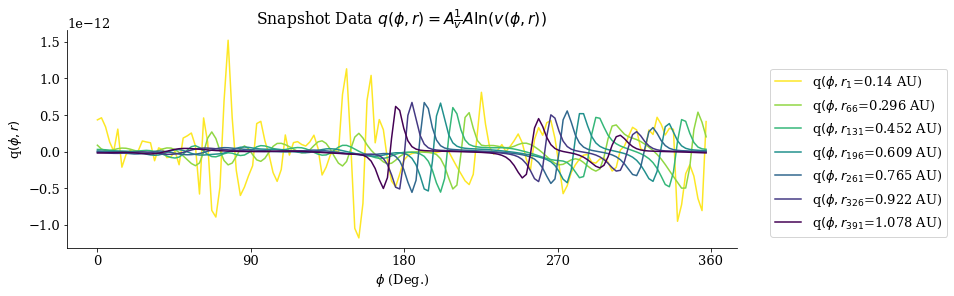

In [128]:
plot_heat_data(G, r"Snapshot Data $q(\phi, r) = A\frac{1}{v} A\ln(v(\phi, r))$", variable="q", savefig=True)

# Normalize New Variables


Let 

* $\hat z = z/C_{1}$
* $\hat \rho = \rho/C_{2}$
* $\hat \gamma = \gamma/C_{3}$


$$
\dot{\hat{z}} =  -C_{2} (\hat{z} \odot \hat{\rho} )
$$
 
$$
\dot{\hat \rho} = -C_{2}{\hat{\rho}}^2 + \frac{C_{1}C_{3}}{C_{2}} (\hat{z} \odot \hat{\gamma})
$$


$$
\dot{\hat \gamma} = -\frac{C_{2}^{2}}{C_{3}}A ({\hat{\rho}}^{2}) + C_{1} A (\hat{z} \odot \hat{\gamma})
$$

In [129]:
# set up initial condition by stacking Z and P

C1 = np.std(Z)
C2 = np.std(P)
C3 = np.std(G)

ic_zp = np.hstack((Z[:, 0]/C1, P[:, 0]/C2, G[:, 0]/C3))

In [130]:
C1

0.0006336741815846447

In [131]:
C2

7.1843575030392574e-09

In [132]:
C3

1.7289944715170359e-13

In [133]:
# initialize FOM H sparse matrix 
H = sparse.lil_matrix((3*n, 9*(n**2)))

In [134]:
H.shape

(450, 202500)

In [135]:
# Z- DYNAMICS
# zp
# verified!
for ii in range(n):
    d = ii*(3*n) + n + ii
    H[ii, d] = -C2

In [136]:
np.max(np.abs(-C2 * (Z[:, 0]/C1) * (P[:, 0]/C2) - 
              (H @ np.kron(ic_zp, ic_zp))[:n]))

1.3234889800848443e-23

In [137]:
# P- DYNAMICS 
# -p^2
# verified!
for ii in np.arange(n, 2*n): 
    d = ii*(3*n) + ii
    H[ii, d] = -C2

In [138]:
np.max(np.abs(-1*P[:, 0]* P[:, 0]/C2 - 
              (H @ np.kron(ic_zp, ic_zp))[n:2*n]))

1.3234889800848443e-23

In [139]:
# P- dynamics
# g*z
# verified!
for ii in np.arange(n, 2*n):
    d = (ii - n)*(3*n) + n + ii
    H[ii, d] = C1*C3/C2

In [140]:
np.max(np.abs((-P[:, 0]* P[:, 0]/C2 + G[:, 0]*Z[:, 0]/C2) - (H @ np.kron(ic_zp, ic_zp))[n:2*n]))

1.0587911840678754e-22

In [141]:
# G- DYNAMICS
# -Ap^2
# verified!
for ii in range(2*n, 3*n):
    d_prev = (ii - n)*(3*n) + ii - n 
    d_next = ((ii + 1) - n)*(3*n) + (ii + 1) - n
    C = (C2**2)/C3
    # periodic boundary conditions. 
    if ii == 3*n - 1:
        H[ii, d_prev] = C*omega_rot/dp
        H[ii, (n)*(3*n) + n ] = - C*omega_rot/dp
    else:
        H[ii, d_prev] = C*omega_rot/dp
        H[ii, d_next] = -C*omega_rot/dp 

In [142]:
np.max(np.abs(-A_mat @ (P[:, 0]* P[:, 0])/C3 - (H @ np.kron(ic_zp, ic_zp))[2*n:3*n]))

5.955700410381799e-23

In [143]:
# G - DYNAMICS
# A g*z
for ii in range(2*n, 3*n):
    d_prev = (ii - 2*n)*(3*n) + ii
    d_next = ((ii + 1) - 2*n)*(3*n) + (ii + 1)
    
    # periodic boundary conditions. 
    if ii == 3*n - 1:
        H[ii, d_prev] += -C1*omega_rot/dp
        H[ii, 2*n] += C1*omega_rot/dp
    else:
        H[ii, d_prev] += -C1*omega_rot/dp
        H[ii, d_next] += C1*omega_rot/dp

In [144]:
np.max(np.abs(A_mat@(-P[:, 0]* P[:, 0]/C3) +A_mat@(G[:, 0]* Z[:, 0]/C3) 
              - (H@np.kron(ic_zp, ic_zp))[2*n:3*n]))

2.6469779601696886e-22

In [145]:
def dynamics_quadradic_system(t, vec):
    return H @ np.kron(vec, vec)

In [146]:
# solve the system numerically iterate. 
ODE_SOLVER = solve_ivp(fun=dynamics_quadradic_system, 
                     t_span=[r_new[0].value, r_new[-1].value], 
                     y0=ic_zp, 
                     t_eval=r_new.value, 
                     method="BDF")

In [147]:
HX_recon = ODE_SOLVER.y
print(f"shape of HX system reconstruction:\t{HX_recon.shape}")

shape of HX system reconstruction:	(450, 400)


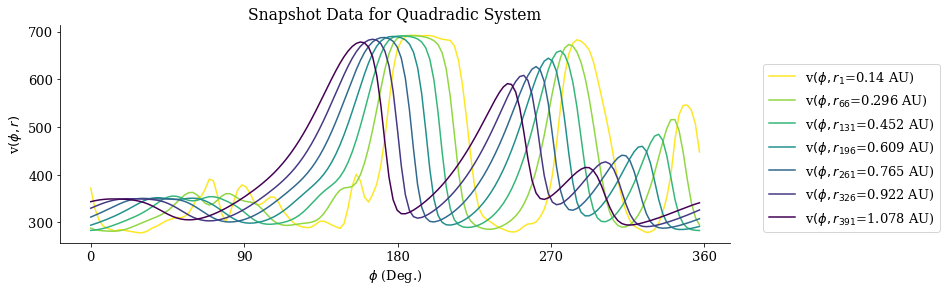

In [148]:
plot_heat_data(1/(HX_recon[:n, :]*C1), r"Snapshot Data for Quadradic System", variable="v")

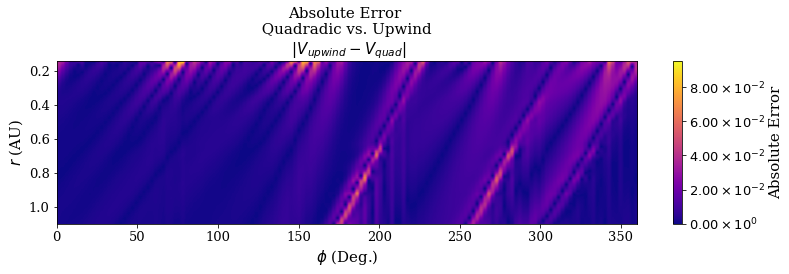

In [149]:
fig, ax = plt.subplots(figsize=(13, 3))
pos = ax.imshow(np.abs(1./(HX_recon[:n, :].T*C1) - (V.T)), extent=[0,360, r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], cmap="plasma", aspect="auto")
ax.set_xlabel(r"$\phi$ (Deg.)", fontsize=15)
ax.set_ylabel("$r$" + " (AU)", fontsize=15)
ax.set_title("Absolute Error \n Quadradic vs. Upwind \n $|V_{upwind} - V_{quad}|$", fontsize=15)
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
cbar = fig.colorbar(pos, ax=ax, format=ticker.FuncFormatter(fmt))
cbar.ax.tick_params(labelsize=13)
_ = cbar.ax.set_ylabel('Absolute Error', rotation=90, fontsize=15)

## Normalize state variables by constant

In [150]:
def transform_from_znorm_to_v(Xres):
    # Transform from Z normalized to Z
    Z = Xres * C1
    # Transform from Z to V
    return 1/Z

In [151]:
Znorm = Z/C1
Pnorm = P/C2
Gnorm = G/C3

## Stack Normalized Variables $[\hat z, \hat \rho, \hat \gamma]$

In [152]:
X = np.vstack((Znorm, Pnorm, Gnorm))

In [153]:
print(f"shape of X:\t{X.shape}")

shape of X:	(450, 400)


## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [154]:
# set up the first l indexes used for training. 
l = int(0.8*len(r_new))

In [155]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [156]:
r_train = r_new[:l]
r_test = r_new[l:-1]

In [157]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r_new[0].to(u.AU)) + " to " + str(r_new[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r_new[l].to(u.AU)) + " to " + str(r_new[-1].to(u.AU)))

X train shape (450, 320)
Radial distance train: 0.13951401782886472 AU to 0.9095475030786826 AU

X test shape (450, 79)
Radial distance test: 0.9095475030786826 AU to 1.0996495197497314 AU


## Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

Another approach is to evaluate the number of singular values that capture 99.99% of the cumulative energy in the system. 

In [158]:
svdvals = la.svdvals(X_train)

In [159]:
# Calculate the cumulative energy.
thresh = .99995
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 22


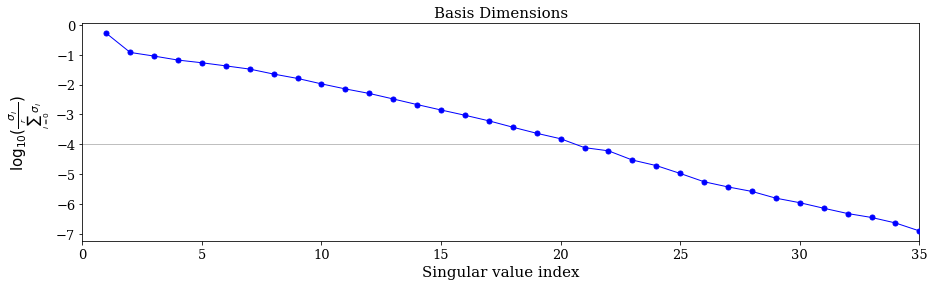

In [160]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
# plot singluar values cumulative energy
ax.plot(np.arange(1, 36), np.log10(svdvals[:35]/np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
ax.hlines(-4, 0, 35, color="black", linewidth=.5, alpha=.5)

_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, 35)
_ = ax.set_xlabel(r"Singular value index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{i=0}^{r} \sigma_{i}})$", fontsize=15)
_ = ax.set_title(r"Basis Dimensions", fontsize=15)

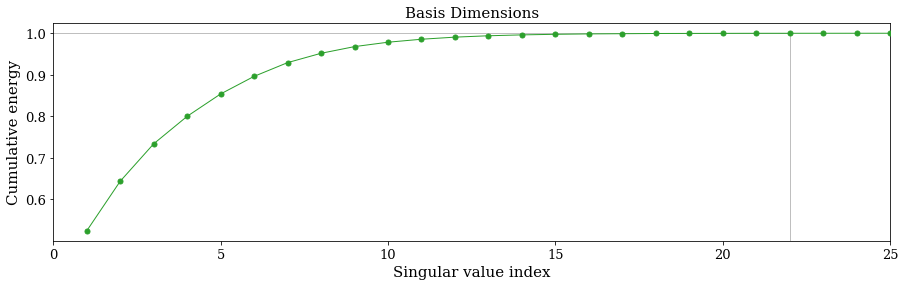

In [161]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, 'C2.-', ms=10, lw=1, zorder=3)
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
ax.hlines(thresh, 0, rank, color="black", linewidth=.5, alpha=.5)
ax.vlines(rank, 0, thresh, color="black", linewidth=.5, alpha=.5)
# set up axis. 
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, 25)
_ = ax.set_xlabel(r"Singular value index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative energy", fontsize=15)
_ = ax.set_title(r"Basis Dimensions", fontsize=15)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [162]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (450, 22)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

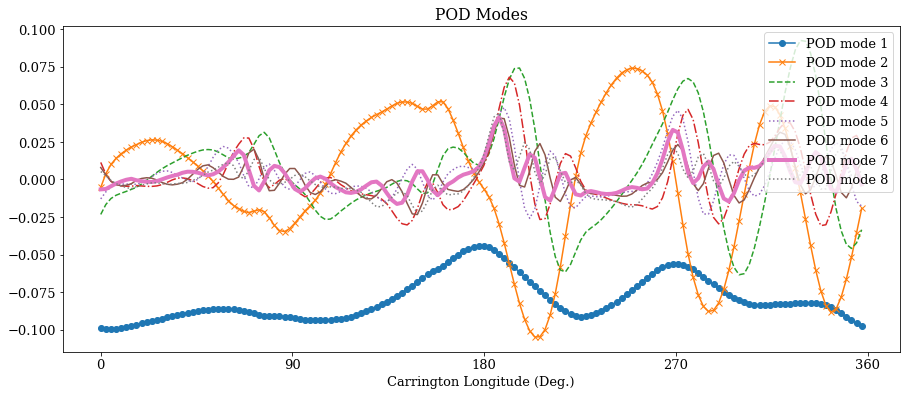

In [163]:
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot((180/np.pi) * p_new, Vr[:n,0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p_new, Vr[:n,1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p_new, Vr[:n,2], "--", label=f"POD mode {3}")
ax.plot((180/np.pi) * p_new, Vr[:n,3], "-.", label=f"POD mode {4}")
ax.plot((180/np.pi) * p_new, Vr[:n,4], ":", label=f"POD mode {5}")
ax.plot((180/np.pi) * p_new, Vr[:n,5], "-", label=f"POD mode {6}")
ax.plot((180/np.pi) * p_new, Vr[:n,6], "-", linewidth=4,  label=f"POD mode {7}")
ax.plot((180/np.pi) * p_new, Vr[:n,7], ":", label=f"POD mode {8}")


    
ax.set_xlabel("Carrington Longitude (Deg.)")
ax.set_title("POD Modes")
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [164]:
roi.pre.projection_error(X_train, Vr)

6.808839812137658e-05

### Calculating the right-hand side Data Matrix

If the matrix $H$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

In [165]:
Xdot2 = roi.pre.xdot_uniform(X_train, (r_new[1]-r_new[0]).value, order=6)

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [166]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r_new[1]-r_new[0]).value, order = 6) # Estimate the projected time derivatives.

np.allclose(Vr.T @ Xdot2, Xdot_)                # Same as project the full-order time derivatives.

True

In [167]:
model = roi.InferredContinuousROM("H")
print(model)

Reduced-order model structure: dx / dt = H(x(t) ⊗ x(t))


We now fit the model to the data by solving the least squares problem

In [168]:
model.fit(Vr, X_train, Xdot2, P=10)

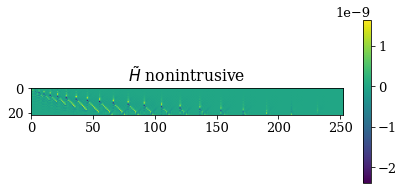

In [169]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.imshow(model.H_)
cbar = fig.colorbar(pos, ax=ax)
_ = ax.set_title(r"$\tilde H$ nonintrusive")

In [170]:
(model.H_).shape

(22, 253)

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [171]:
X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_new[1]- r_new[0]).value)
X_ROM.shape

(450, 400)

In [172]:
V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])
V_ROM.shape

(150, 400)

In [173]:
np.shape(Vr)

(450, 22)

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

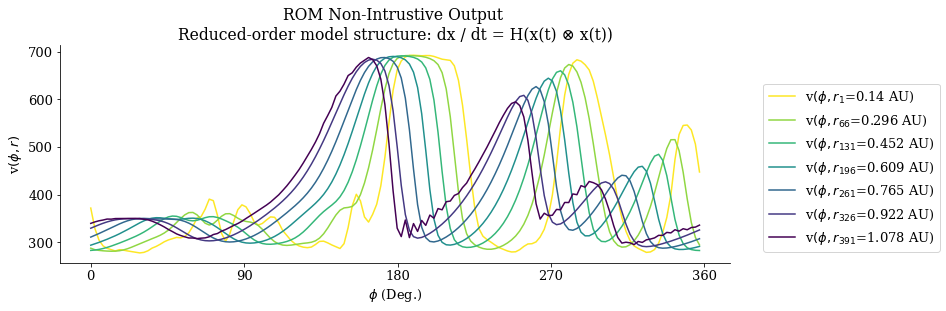

In [181]:
plot_heat_data(V_ROM, "ROM Non-Intrustive Output \n" + str(model), savefig=True)

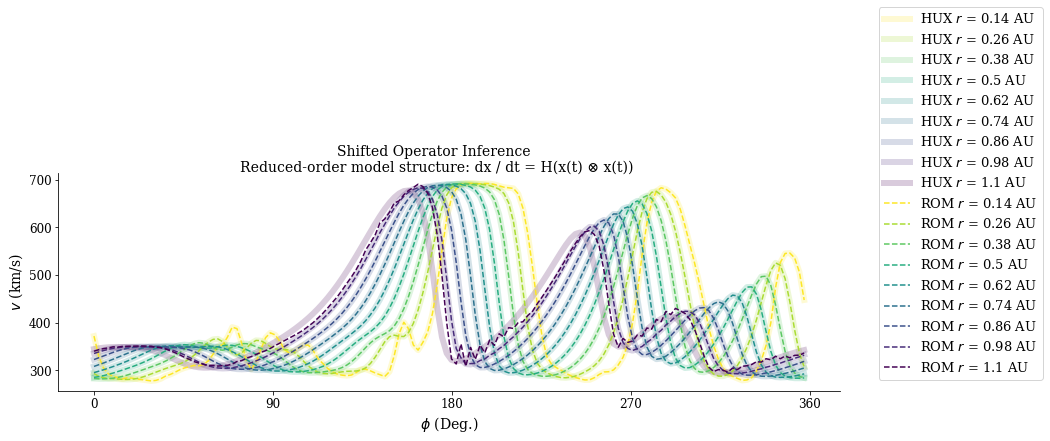

In [183]:
sample_columns = np.arange(0, len(r_new), int(len(r_new)//8))
sample_columns = np.append(sample_columns, len(r_new) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p_new*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r_new[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p_new*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"ROM $r$ = " + 
            str(round(r_new[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("figs/opinf_results_quadratic.png", dpi=500, bbox_inches='tight')


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

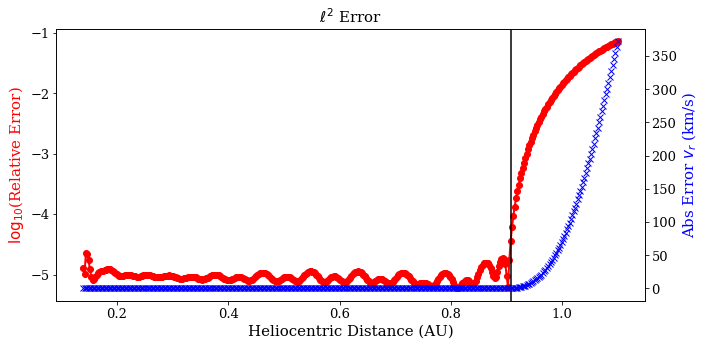

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error", fontsize=15)
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r", fontsize=15)
_ = ax.set_xlabel("Heliocentric Distance (AU)", fontsize=15)

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b", fontsize=15)

plt.tight_layout()

In [178]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 1.432267%


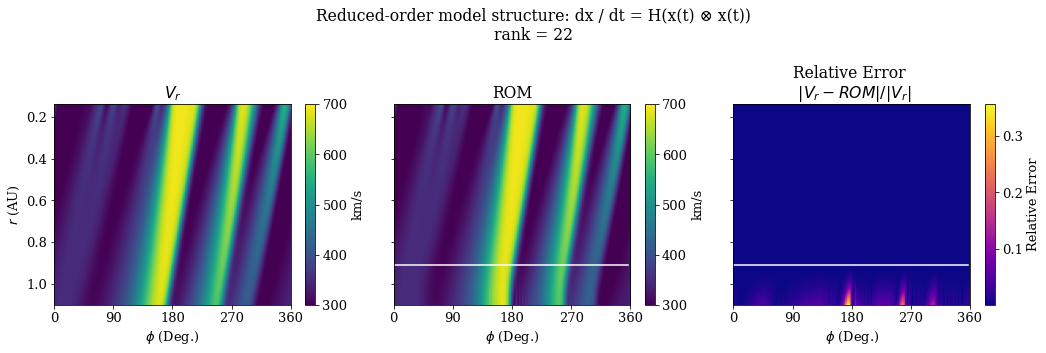

In [185]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r$ (AU)")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)
ax[0].set_xticks([0, 90, 180, 270, 360])

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)
ax[1].set_xticks([0, 90, 180, 270, 360])

pos = ax[2].imshow(np.abs((V_ROM.T - V.T))/np.abs(V.T), extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

ax[2].set_xticks([0, 90, 180, 270, 360])
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

plt.savefig("quadratic_rom_not_scaled_result.png", bbox_inches='tight')

In [180]:
print("mean relative error = ", np.mean(np.abs(V_ROM.T - V.T)/np.abs(V.T)))

mean relative error =  0.0026391492903139655


# Can we improve prediction by projecting to a higher basis subspace? Find the optimal rank. 

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


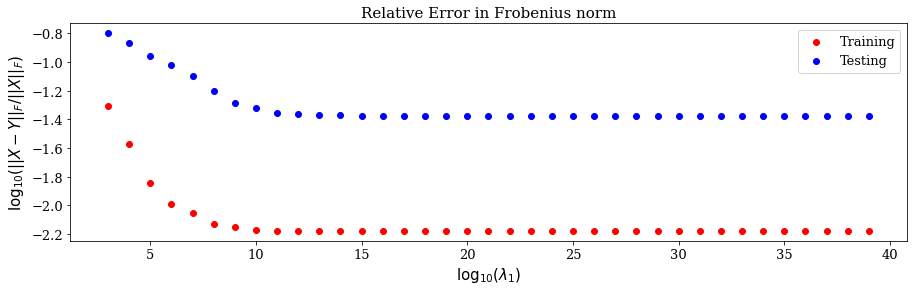

In [79]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(3, 40):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$", fontsize=15)
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$", fontsize=15)
_ = ax.set_title("Relative Error in Frobenius norm", fontsize=15)
_ = plt.legend()

# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$

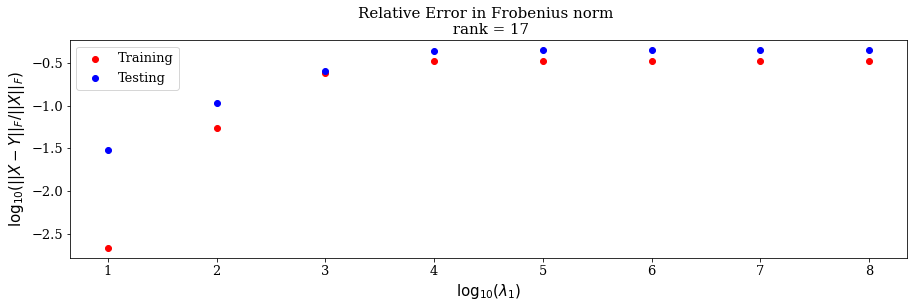

In [80]:
fig, ax = plt.subplots(figsize=(15, 4))

error = np.inf
lam1 = 0
for coeff in [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
        curr_error = roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]
        if curr_error < error:
            error = curr_error
            lam1 = coeff
        
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$", fontsize=15)
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$", fontsize=15)
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank), fontsize=15)
_ = plt.legend()

In [81]:
lam1

10.0

In [82]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)# Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)# Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")# Define the model structure.
model.fit(Vr, X_train, Xdot, P=lam1) # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])
V_ROM.shape

(100, 400)

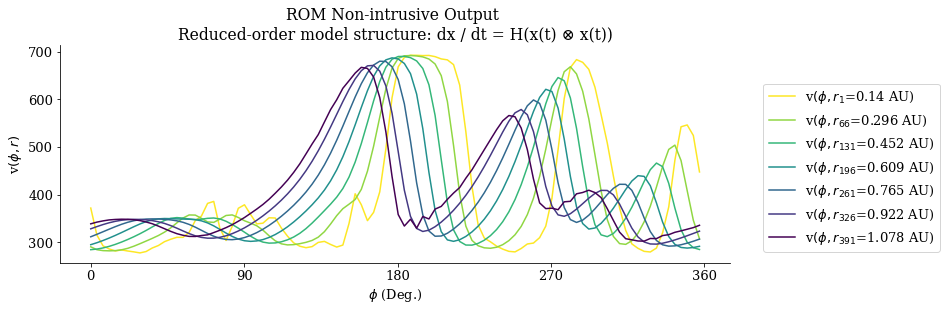

In [83]:
plot_heat_data(V_ROM, "ROM Non-intrusive Output \n" + str(model))

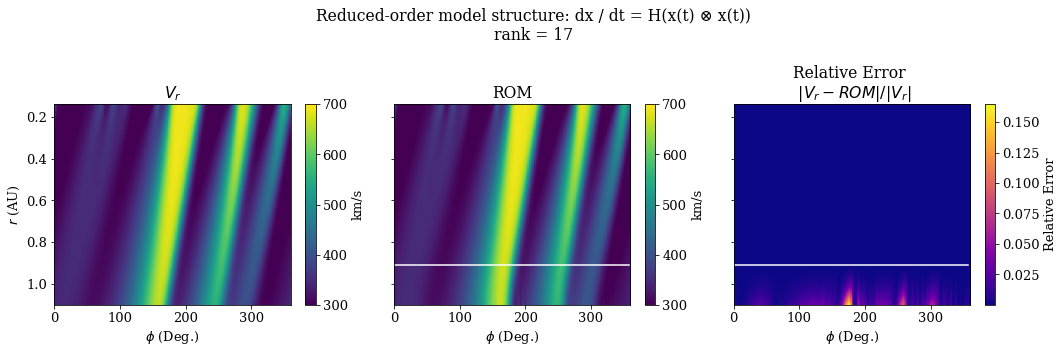

In [84]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r$ (AU)")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs((V_ROM.T - V.T))/np.abs(V.T), extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

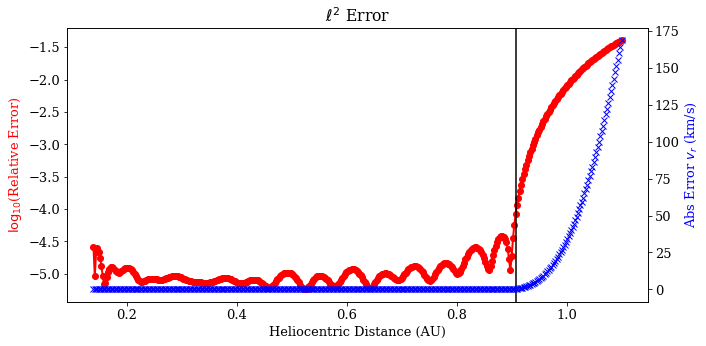

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [86]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 0.787673%


# Compute intrusive $H_{r}$ matrix

## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

#### $H_{r} = V^{\top}H(V \otimes V)$

In [87]:
intrusive_model = roi.IntrusiveContinuousROM("H")
intrusive_model.fit(Vr, {"H":H})
X_ROM_intrusive = intrusive_model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_new[1] - r_new[0]).value)

In [88]:
V_ROM_intrusive = transform_from_znorm_to_v(X_ROM_intrusive[:n, :])
V_ROM_intrusive.shape

(100, 400)

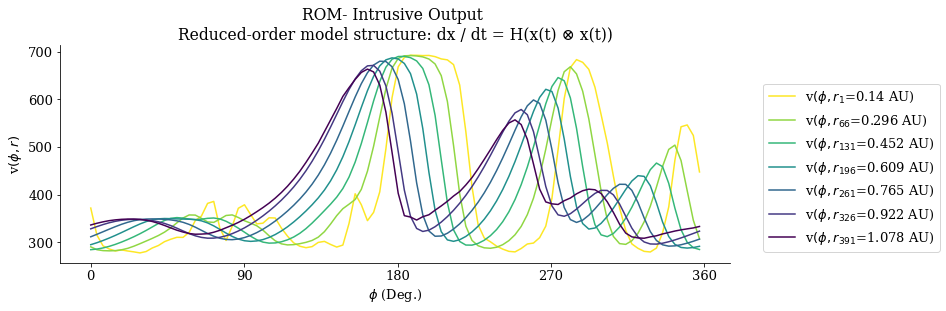

In [89]:
plot_heat_data(V_ROM_intrusive, "ROM- Intrusive Output \n" + str(model))

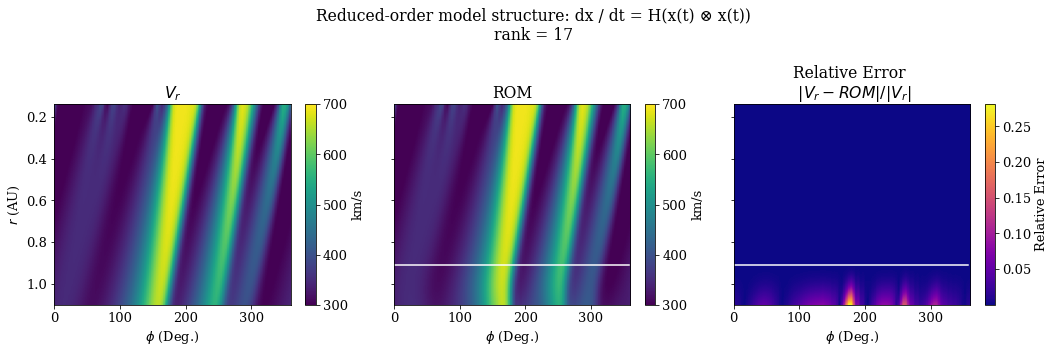

In [90]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r$ (AU)")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_intrusive.T, extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs((V_ROM_intrusive.T - V.T))/np.abs(V.T), extent=[0,360,r_new[-1].to(u.AU).value,r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

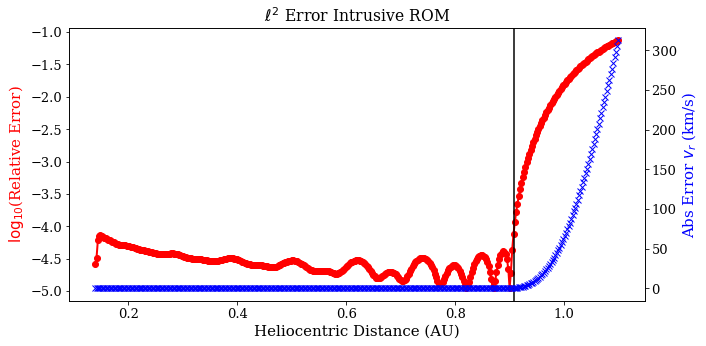

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err_intrusive, rel_l2err_intrusive = roi.post.lp_error(V, V_ROM_intrusive)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err_intrusive),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error Intrusive ROM")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r", fontsize=15)
_ = ax.set_xlabel("Heliocentric Distance (AU)", fontsize=15)

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err_intrusive, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b",fontsize=15)

plt.tight_layout()

In [92]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM_intrusive)
print(f"Relative error: {rel_froerr:%}")

Relative error: 1.503655%


# Can we improve intrusive method prediction by projecting to a higher basis subspace? Find the optimal rank. 

KeyboardInterrupt: 

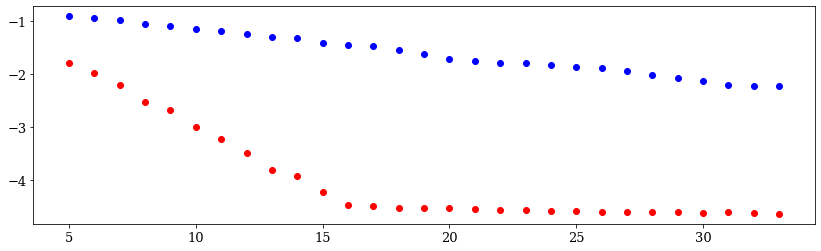

In [93]:
fig, ax = plt.subplots(figsize=(14, 4))

for r_val in np.arange(5, 60):
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)# Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)# Calculate the right-hand side matrix.
    intrusive_model = roi.IntrusiveContinuousROM("H")
    intrusive_model.fit(Vr, {"H":H})
    X_ROM_intrusive = intrusive_model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_new[1] - r_new[0]).value)
    V_ROM_intrusive = transform_from_znorm_to_v(X_ROM_intrusive[:n, :])

    if np.shape(X) == np.shape(X_ROM):
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], V_ROM_intrusive[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], V_ROM_intrusive[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")

_ = ax.set_xlabel("Rank (Basis Size)", fontsize=15)
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$", fontsize=15)
_ = ax.set_title("Relative Error of Testing Dataset in Frobenius Norm\n Intrusive Method", fontsize=15)
_ = plt.legend()

# Comparison of Intrusive vs. Non-intrustive method

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err), "-o", c="r", label="non-intrusive")
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err_intrusive), "-o", c="b", label="intrusive")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error", fontsize=15)
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", fontsize=15)
_ = ax.set_xlabel("Heliocentric Distance (AU)", fontsize=15)


plt.legend()
plt.tight_layout()

# Quadradic-Linear ROM  Form

$$\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat c + \hat{A}\hat{\mathbf{x}}(t) + \hat{H}\left(\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\right)(t) $$



Regularization is essential to avoid overfitting [1].


The optimization problem can be rewriten in the form

$$
    \min_{O}\in\mathbb{R}^{r\times d(r,m)}\left\|DO^{T} - R^{T}\right\|_{F}^2,
$$

where 

$$
O = [\hat A \quad  \hat H]
$$
$$
D = [\hat{\mathbf{x}} \quad  \hat{\mathbf{x}}\otimes\hat{\mathbf{x}}]
$$

$$
R = [\dot{\hat{\mathbf{x}}}]
$$

Then, the regularization constarints enforce that 

$$
    \min_{O}\in\mathbb{R}^{r\times d(r,m)}\left\|DO^{T} - R^{T}\right\|_{F}^2 + \|\Gamma O^{T} \|_{F}^{2},
$$

where the Tikhonov matrix $\Gamma = diag(\lambda_{1} I_{(r)}, \lambda_{2} I_{(r^2)})$ resulting in $L_{2}$ regularization. 

The solution to Eq. above is then obtained by solving the normal equations,

$$
O^{*} = (D^{T}D + \Gamma^{T} \Gamma)^{-1}D^{T}R^{T}
$$

For a review of the Tikhonov regularization and normal equations watch this: https://www2.helsinki.fi/fi/unitube/video/c72b6af1-1a9f-40fa-960f-f11d9b7340ef

In [ ]:
def regularizer(r, λ1, λ2, λ3=None):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    If λ3 is given, the entries of the cubic operator are penalized by λ3.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.
    λ2 : float or None
        Regularization hyperparameter for the cubic operator (if present).
    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    if λ3 is None:
        diag𝚪 = np.full(r2+1, λ1)
        diag𝚪[r1:-1] = λ2
    else:
        r3 = r2 + r*(r + 1)*(r + 2)//6
        diag𝚪 = np.full(r3+1, λ1)
        diag𝚪[r1:r2] = λ2
        diag𝚪[r2:-1] = λ3
    return diag𝚪

In [ ]:
#Calculate the cumulative energy
thresh = .9999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

# SVD 
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

In [ ]:
model = roi.InferredContinuousROM("cAH")
print(model)

In [ ]:
error = np.inf
lam1 = 0
lam2 = 0

for l1 in [1e1, 1e2, 1e3]:# get the svd rank based on total cumulative energy. 
    for l2 in [1e1, 1e2, 1e3]:
        Vr, _ = roi.pre.pod_basis(X_train, r=rank)                      
        Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)              
        model = roi.InferredContinuousROM(modelform="cAH")               
        model.fit(Vr, X_train, Xdot, P=regularizer(rank, l1, l2))                           
        X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) 
        V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])
        if np.shape(X_ROM) == np.shape(X):
            curr_error = roi.post.frobenius_error(V, V_ROM)[1]
            if curr_error < error:
                error = curr_error
                lam1 = l1
                lam2 = l2

In [ ]:
lam1

In [ ]:
lam2

In [ ]:
#Calculate the cumulative energy
thresh = .9999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

# SVD 
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

In [ ]:
model.fit(Vr, X_train, Xdot, P=regularizer(rank, l1, l2))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)
_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 1))
pos = ax.imshow(model.H_)
cbar = fig.colorbar(pos, ax=ax)
_ = ax.set_title(r"$\tilde H$")

In [ ]:
X_ROM = model.predict(X[:, 0], r_new.value, method="BDF")
X_ROM.shape

V_ROM = transform_from_znorm_to_v(X_ROM[:n, :])

In [ ]:
plot_heat_data(V_ROM, "ROM Output \n " + str(model))

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_test[-1].to(u.AU).value, r_new[0].to(u.AU).value], vmin=300,
                   vmax=700, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_title("$V_{r}$")
ax[0].set_ylabel(r"$r (AU)$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_test[-1].to(u.AU).value,r_new[0].to(u.AU).value], vmin=300, vmax=700, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(p_new*(180/np.pi), r_new[l].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r_test[-1].to(u.AU).value,r_new[0].to(u.AU).value], cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_new[l].to(u.AU).value * np.ones(n), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [ ]:
print("mean relative error = ", np.mean(np.abs(V_ROM.T - V.T)/np.abs(V.T)))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err), "o", c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [ ]:
# initialize the training length. 
l1, l2, l3 = 200, 250, 300


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [ ]:
r_train1 = r_new[:l1]
r_test1 = r_new[l1:-1]

r_train2 = r_new[:l2]
r_test2 = r_new[l2:-1]

r_train3 = r_new[:l3]
r_test3 = r_new[l3:-1]

In [ ]:
# l1 = compute the results for quadradic with 31 modes.
rank=16
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1e1)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
V_ROM1 = transform_from_znorm_to_v(X_ROM1[:n, :])


# l2 = compute the results for quadradic with 31 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1e1)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
V_ROM2 = transform_from_znorm_to_v(X_ROM2[:n, :])

# l3 = compute the results for quadradic with 31 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1e1)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
V_ROM3 = transform_from_znorm_to_v(X_ROM3[:n, :])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(l1))
_ = ax.axvline(r_train1[-1].to(u.AU).value, c="b")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(l2))
_ = ax.axvline(r_train2[-1].to(u.AU).value, c="r")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(l3))
_ = ax.axvline(r_train3[-1].to(u.AU).value, c="g")

_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()

# Observations

**Stability** - for larger rank, the predicted velocity function exhibits artificial oscillations/suffers from instability.  Yet, remains reconstruction of the training trajetcories is highly accurate- potentially overfitting to the training dataset. 

**Model Form** - Adding higher order terms to the reduced order Operator Inference model improves the prediction of solar wind velocity. Howeever, there is not a significant difference from the Quadradic and Cubic form. 

**Regularization** - Regularization in $l_{2}$ (Tikhonov regularization) prevents overfitting and sets bounds on the linear operators.

**Sensitivity to the number of training snapshots** - If the basis dimensions are low then the performance of OpInf is fairly stable, otherwise, the number of snapshots highly effects performance. 